In [1]:
from field_free import field_free
from stark import dipole_me_matrix, field_free_matrix
from thz_field import thz_field
from tdse import propagate
from constants import DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS
import camphor

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

In [2]:
# rotational constants in MHz
rot_a = camphor.rot_a
rot_b = camphor.rot_b
rot_c = camphor.rot_c

# dipole moment in Debye
dipole_debye_abc_R = np.copy(camphor.dipole_expt_deb)
dipole_debye_abc_S = np.copy(camphor.dipole_expt_deb)
dipole_debye_abc_S[2] *= -1

print(camphor.__doc__)
print("Rotational constants (MHz):", rot_a, rot_b, rot_c)
print("(a, b, c) principal-frame components of dipole moment for R-enantiomer (Debye):", dipole_debye_abc_R)
print("(a, b, c) principal-frame components of dipole moment for S-enantiomer (Debye):", dipole_debye_abc_S)

Molecular data for camphor molecule

Rotational constants (in MHz):
    - supersonic expansion FTMW spectra, Kisiel, et al., PCCP 5, 820 (2003), https://doi.org/10.1039/B212029A
Dipole moment:
    - calculated (in au), using CCSD(T)/aug-cc-pVTZ in the frozen-core approximation. 
    - measured (in Debye), using supersonic expansion FTMW spectrum, Kisiel, et. al., PCCP 5, 820 (2003), https://doi.org/10.1039/B212029A

Rotational constants (MHz): 1446.968977 1183.36711 1097.101031
(a, b, c) principal-frame components of dipole moment for R-enantiomer (Debye): [-2.9934 -0.7298  0.0804]
(a, b, c) principal-frame components of dipole moment for S-enantiomer (Debye): [-2.9934 -0.7298 -0.0804]


In [3]:
max_j = 6

rot_enr = {}
rot_vec = {}
rot_assignment = {}
rot_func_on_grid = {}

for j in range(max_j + 1):
    abc_axes, rot_enr[j], rot_vec[j], rot_assignment[j], grid, rot_func_on_grid[j] = (
        field_free(j, rot_a, rot_b, rot_c)
    )

print("(a, b, c) principal-frame axes correspond to molecular-frame axes:", abc_axes)

dipole_debye_xyz_R = [dipole_debye_abc_R["xyz".index(cart)] for cart in abc_axes]
print(
    "(x, y, z) molecular-frame components of dipole moment for R-1,2-propanediol:",
    dipole_debye_xyz_R,
)

dipole_debye_xyz_S = [dipole_debye_abc_S["xyz".index(cart)] for cart in abc_axes]
print(
    "(x, y, z) molecular-frame components of dipole moment for S-1,2-propanediol:",
    dipole_debye_xyz_S,
)

(a, b, c) principal-frame axes correspond to molecular-frame axes: ('z', 'y', 'x')
(x, y, z) molecular-frame components of dipole moment for R-1,2-propanediol: [0.0804, -0.7298, -2.9934]
(x, y, z) molecular-frame components of dipole moment for S-1,2-propanediol: [-0.0804, -0.7298, -2.9934]


In [4]:
print("Rotational energies\n# (J, ka, kc)  E (MHz)")
for j in rot_enr.keys():
    for i, (e, (j, ka, kc)) in enumerate(zip(rot_enr[j], rot_assignment[j])):
        print(i, (j, ka, kc), e) 

Rotational energies
# (J, ka, kc)  E (MHz)
0 (0, 0, 0) 0.0
0 (1, 0, 1) 2280.4681410000003
1 (1, 1, 1) 2544.0700080000006
2 (1, 1, 0) 2630.336087
0 (2, 0, 2) 6823.470466118668
1 (2, 1, 2) 7018.740211
2 (2, 1, 1) 7277.538447999998
3 (2, 2, 1) 8068.344049
4 (2, 2, 0) 8086.278005881331
0 (3, 0, 3) 13597.728190348826
1 (3, 1, 3) 13720.496657144093
2 (3, 1, 2) 14235.701407244376
3 (3, 2, 2) 14909.748472000001
4 (3, 2, 1) 14994.829127651166
5 (3, 3, 1) 16453.671862855903
6 (3, 3, 0) 16456.063586755623
0 (4, 0, 4) 22573.41925938218
1 (4, 1, 4) 22640.018293018275
2 (4, 1, 3) 23486.367220034346
3 (4, 2, 3) 24017.5225192709
4 (4, 2, 0) 24248.521240547965
5 (4, 3, 2) 25605.36319698173
6 (4, 3, 1) 25621.675059965655
7 (4, 4, 1) 27726.5384307291
8 (4, 4, 0) 27726.80186006984
0 (5, 0, 5) 33736.3697402577
1 (5, 1, 5) 33768.7372462861
2 (5, 1, 4) 35000.84517070202
3 (5, 2, 4) 35380.15987035599
4 (5, 2, 1) 35848.48126429395
5 (5, 3, 3) 37048.52547293373
6 (5, 3, 0) 37110.38253302526
7 (5, 4, 2) 39168.58

In [5]:
# dipole matrix elelements
dipole_matrix_R = dipole_me_matrix(max_j, rot_vec, dipole_debye_xyz_R, linear=False)
dipole_matrix_S = dipole_me_matrix(max_j, rot_vec, dipole_debye_xyz_S, linear=False)

# field-free Hamiltonian - diagonal matrix with rotational energies
h0_matrix, assignment = field_free_matrix(max_j, rot_enr, rot_assignment)

In [6]:
print("Rotational energies\n# (J, ka, kc, m)  E (MHz)")
for i, (j, ka, kc, m) in enumerate(assignment):
    print(i, (j, ka, kc, m), h0_matrix[i, i])

Rotational energies
# (J, ka, kc, m)  E (MHz)
0 (0, 0, 0, 0) 0.0
1 (1, 0, 1, -1) 2280.4681410000003
2 (1, 0, 1, 0) 2280.4681410000003
3 (1, 0, 1, 1) 2280.4681410000003
4 (1, 1, 1, -1) 2544.0700080000006
5 (1, 1, 1, 0) 2544.0700080000006
6 (1, 1, 1, 1) 2544.0700080000006
7 (1, 1, 0, -1) 2630.336087
8 (1, 1, 0, 0) 2630.336087
9 (1, 1, 0, 1) 2630.336087
10 (2, 0, 2, -2) 6823.470466118668
11 (2, 0, 2, -1) 6823.470466118668
12 (2, 0, 2, 0) 6823.470466118668
13 (2, 0, 2, 1) 6823.470466118668
14 (2, 0, 2, 2) 6823.470466118668
15 (2, 1, 2, -2) 7018.740211
16 (2, 1, 2, -1) 7018.740211
17 (2, 1, 2, 0) 7018.740211
18 (2, 1, 2, 1) 7018.740211
19 (2, 1, 2, 2) 7018.740211
20 (2, 1, 1, -2) 7277.538447999998
21 (2, 1, 1, -1) 7277.538447999998
22 (2, 1, 1, 0) 7277.538447999998
23 (2, 1, 1, 1) 7277.538447999998
24 (2, 1, 1, 2) 7277.538447999998
25 (2, 2, 1, -2) 8068.344049
26 (2, 2, 1, -1) 8068.344049
27 (2, 2, 1, 0) 8068.344049
28 (2, 2, 1, 1) 8068.344049
29 (2, 2, 1, 2) 8068.344049
30 (2, 2, 0, -2) 80

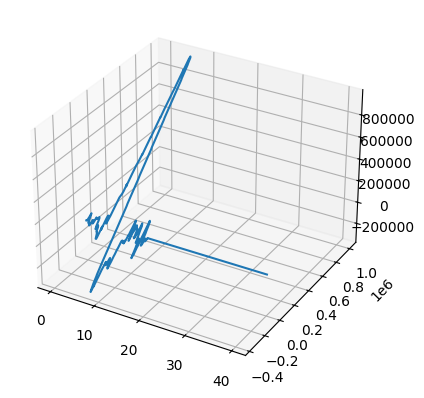

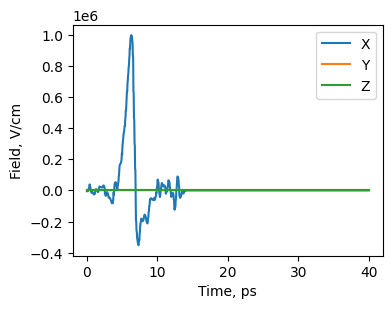

In [7]:
# field, in V/cm, as a function of time, in picoseconds
thz_pulse_delay = 0
field_z = lambda time: np.array([0, 0, thz_field(time, peak_field=100e4)])
field_x = lambda time: np.array(
    [thz_field(time - thz_pulse_delay, peak_field=100e4), 0, 0]
)
field = lambda time: field_x(time) #+ field_z(time)

time = np.linspace(0, 40, 1000)

# parametric plot
ax = plt.figure().add_subplot(projection="3d")
ax.plot(
    time,
    [field_x(t)[0] for t in time],
    [field_z(t)[2] for t in time],
)
plt.show()

# 2D field projections plot
plt.figure(figsize=(4, 3))
plt.plot(time, np.array([field(t) for t in time]), label=["X", "Y", "Z"])
plt.xlabel("Time, ps")
plt.ylabel("Field, V/cm")
plt.legend()
plt.show()

In [8]:
# convert field-free Hamiltonian from MHz to 1/ps
h0_matrix_invps = h0_matrix * 1e-6

In [9]:
# convert dipole matrix elelements to units cm/(V*ps)
# to make sure that when it is multiplied with field in V/cm, the final units will be 1/ps
dipole_matrix_invps_R = dipole_matrix_R * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

# solve TDSE

# initial population - ground state only
coefs_R = np.zeros(len(h0_matrix_invps), dtype=np.complex128)
coefs_R[0] = 1.0

coefs_time_R = propagate(
    start_time=0.0,
    end_time=200,
    time_step=0.01,
    field=field,
    field_free_matrix=h0_matrix_invps,
    dipole_matrix=dipole_matrix_invps_R,
    initial_coefs=coefs_R,
    on_update=lambda i, t, c: (  # print population of state no. 0 at each 100th timestep
        print(
            t.round(2),
            np.abs(c[0]) ** 2,
        )
        if i % 100 == 0
        else None
    ),
)

# keep only every 10th element (resulting time-resolution 0.1 ps)
coefs_time_R = coefs_time_R[0::10]

0.0 0.9999999220844258
1.0 0.9999938088832081
2.0 0.9998387119789918
3.0 0.9991663391669383
4.0 0.9532591240717679
5.0 0.8863157342136082
6.0 0.010530794248595045
7.0 0.005893321739533773
8.0 2.270687906312469e-05
9.0 0.016433773549955604
10.0 0.0167366276276735
11.0 0.017229648112678384
12.0 0.016696056566118195
13.0 0.017264465372287905
14.0 0.016960498902418582
15.0 0.016960498902418582
16.0 0.016960498902418582
17.0 0.016960498902418582
18.0 0.016960498902418582
19.0 0.016960498902418582
20.0 0.016960498902418582
21.0 0.016960498902418582
22.0 0.016960498902418582
23.0 0.016960498902418582
24.0 0.016960498902418582
25.0 0.016960498902418582
26.0 0.016960498902418582
27.0 0.016960498902418582
28.0 0.016960498902418582
29.0 0.016960498902418582
30.0 0.016960498902418582
31.0 0.016960498902418582
32.0 0.016960498902418582
33.0 0.016960498902418582
34.0 0.016960498902418582
35.0 0.016960498902418582
36.0 0.016960498902418582
37.0 0.016960498902418582
38.0 0.016960498902418582
39.0 0.01

In [10]:
# convert dipole matrix elelements to units cm/(V*ps)
# to make sure that when it is multiplied with field in V/cm, the final units will be 1/ps
dipole_matrix_invps_S = dipole_matrix_S * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

# solve TDSE

# initial population - ground state only
coefs_S = np.zeros(len(h0_matrix_invps), dtype=np.complex128)
coefs_S[0] = 1.0

coefs_time_S = propagate(
    start_time=0.0,
    end_time=200,
    time_step=0.01,
    field=field,
    field_free_matrix=h0_matrix_invps,
    dipole_matrix=dipole_matrix_invps_S,
    initial_coefs=coefs_S,
    on_update=lambda i, t, c: (  # print population of state no. 0 at each 100th timestep
        print(
            t.round(2),
            np.abs(c[0]) ** 2,
        )
        if i % 100 == 0
        else None
    ),
)

# keep only every 10th element (resulting time-resolution 0.1 ps)
coefs_time_S = coefs_time_S[0::10]

0.0 0.9999999220844258
1.0 0.9999938088832081
2.0 0.9998387119789918
3.0 0.9991663391669383
4.0 0.9532591240717679
5.0 0.8863157342136082
6.0 0.010530794248595092
7.0 0.005893321739533747
8.0 2.2706879063125724e-05
9.0 0.016433773549955576
10.0 0.01673662762767344
11.0 0.017229648112678332
12.0 0.01669605656611814
13.0 0.01726446537228783
14.0 0.016960498902418502
15.0 0.016960498902418502
16.0 0.016960498902418502
17.0 0.016960498902418502
18.0 0.016960498902418502
19.0 0.016960498902418502
20.0 0.016960498902418502
21.0 0.016960498902418502
22.0 0.016960498902418502
23.0 0.016960498902418502
24.0 0.016960498902418502
25.0 0.016960498902418502
26.0 0.016960498902418502
27.0 0.016960498902418502
28.0 0.016960498902418502
29.0 0.016960498902418502
30.0 0.016960498902418502
31.0 0.016960498902418502
32.0 0.016960498902418502
33.0 0.016960498902418502
34.0 0.016960498902418502
35.0 0.016960498902418502
36.0 0.016960498902418502
37.0 0.016960498902418502
38.0 0.016960498902418502
39.0 0.01

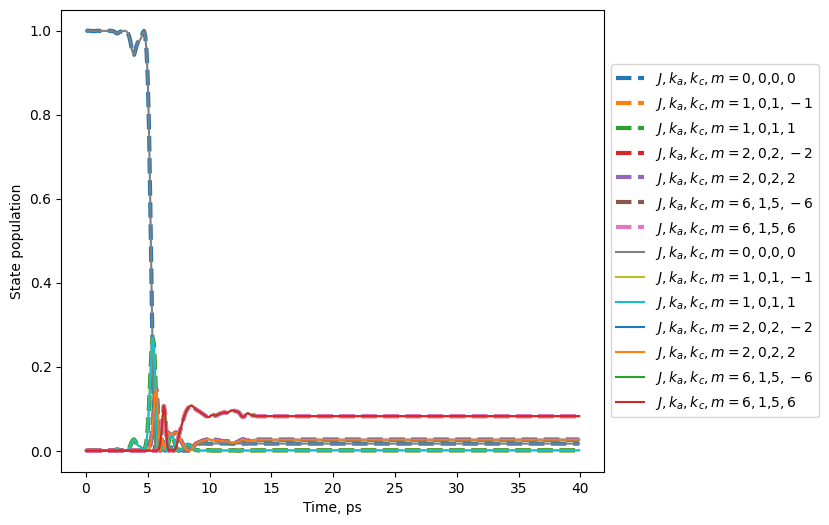

In [11]:
plot_thresh = 1e-1
max_time = 40

# extract time grid
time_list = np.array([time for (ind, time, coef) in coefs_time_R if time < max_time])

# extract populations
populations_time_R = np.array(
    [np.abs(coef) ** 2 for (ind, time, coef) in coefs_time_R if time < max_time]
)
populations_time_S = np.array(
    [np.abs(coef) ** 2 for (ind, time, coef) in coefs_time_S if time < max_time]
)

# plot significant populations
plt.figure(figsize=(7, 6))

for state_ind, population in enumerate(populations_time_R.T):
    if np.max(population) > plot_thresh:
        label = "$J,k_a,k_c,m=$" + ",".join(
            f"{elem}$" for elem in assignment[state_ind]
        )
        plt.plot(time_list, population, label=label, linestyle='--', linewidth=3)

for state_ind, population in enumerate(populations_time_R.T):
    if np.max(population) > plot_thresh:
        label = "$J,k_a,k_c,m=$" + ",".join(
            f"{elem}$" for elem in assignment[state_ind]
        )
        plt.plot(time_list, population, label=label, linestyle='-')
plt.xlabel("Time, ps")
plt.ylabel("State population")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


In [12]:
# grid of Euler angles, as output by `field_free_linear`
alpha, beta, gamma = grid
no_grid_points = len(alpha) * len(beta) * len(gamma)  # total number of grid points
print("total number of points in Euler grid:", no_grid_points)

# arrange field-free rotational wavefunctions on grid in the same order of functions (quantum numbers)
# as used for the field-free and dipole matrix elements
func_on_grid = np.concatenate(
    [rot_func_on_grid[j].reshape(-1, no_grid_points) for j in range(max_j + 1)], axis=0
)

total number of points in Euler grid: 27000


In [13]:
# extract wavepacket coefficients
coefs_R = np.array([coef for (ind, time, coef) in coefs_time_R])

# compute wavepacket on grid of Euler angles
wavepack_on_grid_R = np.dot(func_on_grid.T, coefs_R.T)

dens_on_grid_R = wavepack_on_grid_R * np.conj(wavepack_on_grid_R)
dens_on_grid_R = dens_on_grid_R.real

# reshape density from a 3D direct product grid to the three 1D nested grids
dens_on_grid_R = dens_on_grid_R.reshape(len(alpha), len(beta), len(gamma), -1)

# multiply by spherical volume element \sin\beta
sin_beta = np.sin(beta)
dens_on_grid_R *= sin_beta[None, :, None, None]

In [14]:
# extract wavepacket coefficients
coefs_S = np.array([coef for (ind, time, coef) in coefs_time_S])

# compute wavepacket on grid of Euler angles
wavepack_on_grid_S = np.dot(func_on_grid.T, coefs_S.T)

dens_on_grid_S = wavepack_on_grid_S * np.conj(wavepack_on_grid_S)
dens_on_grid_S = dens_on_grid_S.real

# reshape density from a 3D direct product grid to the three 1D nested grids
dens_on_grid_S = dens_on_grid_S.reshape(len(alpha), len(beta), len(gamma), -1)

# multiply by spherical volume element \sin\beta
sin_beta = np.sin(beta)
dens_on_grid_S *= sin_beta[None, :, None, None]

In [15]:
dens_interpolate_R = RegularGridInterpolator((alpha, beta, gamma), dens_on_grid_R)
max_dens_R = np.max(dens_on_grid_R, axis=(0, 1, 2))

# generate uniformly-distributed samples of Euler angles
npoints_sample = 100000
euler_sample_points = np.random.uniform(
    low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints_sample, 3)
)

# evaluate density on the samples and apply rejection sampling
dens_R = dens_interpolate_R(euler_sample_points) / max_dens_R
eta_R = np.random.uniform(0.0, 1.0, size=len(dens_R))
euler_sample_points = [euler_sample_points[np.where(d > eta_R)] for d in dens_R.T]

# map samples of Euler angles to samples of direction-cosine rotation matrix
rotation_matrix_R = [
    Rotation.from_euler("zyz", points).as_matrix() for points in euler_sample_points
]

In [16]:
dens_interpolate_S = RegularGridInterpolator((alpha, beta, gamma), dens_on_grid_S)
max_dens_S = np.max(dens_on_grid_S, axis=(0, 1, 2))

# generate uniformly-distributed samples of Euler angles
npoints_sample = 100000
euler_sample_points = np.random.uniform(
    low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints_sample, 3)
)

# evaluate density on the samples and apply rejection sampling
dens_S = dens_interpolate_S(euler_sample_points) / max_dens_S
eta_S = np.random.uniform(0.0, 1.0, size=len(dens_S))
euler_sample_points = [euler_sample_points[np.where(d > eta_S)] for d in dens_S.T]

# map samples of Euler angles to samples of direction-cosine rotation matrix
rotation_matrix_S = [
    Rotation.from_euler("zyz", points).as_matrix() for points in euler_sample_points
]

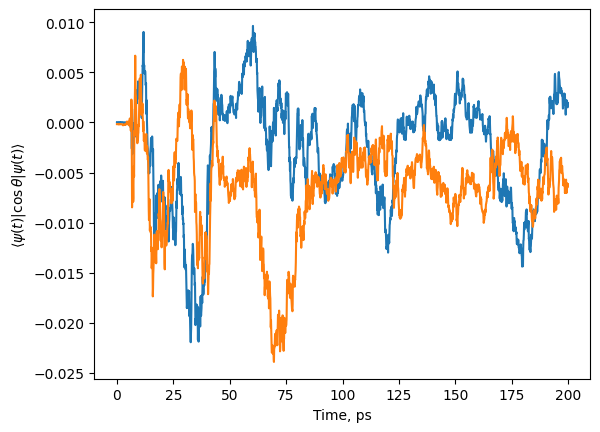

In [17]:
# mol_vector_R = dipole_debye_xyz_R / np.linalg.norm(dipole_debye_xyz_R)
# mol_vector_S = dipole_debye_xyz_S / np.linalg.norm(dipole_debye_xyz_S)
mol_vector_R = [0, 0, 1]
mol_vector_S = [0, 0, 1]

lab_vector_R = [np.dot(rot, mol_vector_R) for rot in rotation_matrix_R]
lab_vector_S = [np.dot(rot, mol_vector_S) for rot in rotation_matrix_S]

cos_theta_R = np.array([np.mean(vec[:, 2]) for vec in lab_vector_R])
cos_theta_S = np.array([np.mean(vec[:, 2]) for vec in lab_vector_S])

time_list = np.array([time for (ind, time, coef) in coefs_time_R])
plt.plot(time_list, cos_theta_R)
plt.plot(time_list, cos_theta_S)
plt.xlabel("Time, ps")
plt.ylabel("$\\langle \\psi(t)|\\cos\\theta|\\psi(t)\\rangle$")
plt.show()

In [18]:
from stark import costheta_me_matrix

# matrix elements <cos(beta)> in rotational field-free basis
costheta_matrix = costheta_me_matrix(max_j, rot_vec, linear=False)

# extract wavepacket coefficients
coefs_R = np.array([coef for (ind, time, coef) in coefs_time_R])  # (time, bas)
coefs_S = np.array([coef for (ind, time, coef) in coefs_time_S])  # (time, bas)

# transform matrix <cos(beta)> to wavepacket representation
costheta_time_R = np.einsum(
    "ti,kij,tj->t", np.conj(coefs_R), costheta_matrix, coefs_R, optimize="optimal"
)
costheta_time_S = np.einsum(
    "ti,kij,tj->t", np.conj(coefs_S), costheta_matrix, coefs_S, optimize="optimal"
)

# check if values are real
print("maximal imaginary component in <cos(beta)> (expected small):", np.max(np.abs(costheta_time_R.imag)))
costheta_time_R = costheta_time_R.real
costheta_time_S = costheta_time_S.real

maximal imaginary component in <cos(beta)> (expected small): 1.5606375258007345e-18


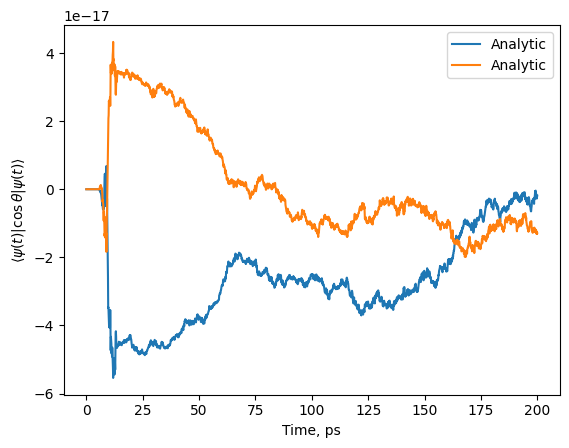

In [19]:
plt.plot(time_list, costheta_time_R, label="Analytic")
plt.plot(time_list, costheta_time_S, label="Analytic")
plt.xlabel('Time, ps')
plt.ylabel('$\\langle \\psi(t)|\\cos\\theta|\\psi(t)\\rangle$')
plt.legend()
plt.show()